In [ ]:
#imports
from re import M
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

In [ ]:
#PDF for value investors
def pdf_value(p, p_0, spread):
  return max((1/(spread/2)) - abs(p_0-p)/pow((spread/2), 2), 0)

# PDF for momentum investors
def pdf_momen(p, p_eq, spread):
  return max((1/(spread/2)) - abs(p_eq-p)/pow((spread/2), 2), 0)

# Expected volume
def volume(p, p_eq, bias):
  if (p < p_eq):
      return (max(p_eq - p, 10)) * bias
  else:
      return (p - p_eq)

In [ ]:
# Evolution for auction w/ only one type of investor
def evolution_1(n, accuracy, p_0, p_eq, spread, vol, shares, bias, form):
  initial_diff = 0;
  price_hist = [p_0] * n
  price_hist[0] = p_eq
  cdf = [0] * accuracy #culmunative dist. func. for volume

  for t in range(1, n): #time periods
    # cdf for volume
    cdf[0] = pdf_value(p_0 - spread/2, p_0, spread) * volume(p_0 - spread/2, p_eq, bias)
    for i in range(1, accuracy):
        # subjective valuation distribution * propensity to invest
        cdf[i] = cdf[i-1] + pdf_value(p_0 - spread/2 + spread/(accuracy - 1) * i, p_0, spread) * volume(p_0 - spread/2 + spread/(accuracy - 1) * i, p_eq, bias)

    cdf = [x * (vol/(cdf[accuracy - 1])) for x in cdf] # normalizes volume

    # location on the cdf which corresponds to the current price
    eq_i = max(0 , min(accuracy - 1, math.floor((p_eq - p_0 + spread/2)/(spread/(accuracy - 1))))) # line on curve corresponding to current price

    # finds p_eq based on price implied from volume
    if (form == 1): #auction w/o shorting
      diff = (vol - cdf[eq_i])/shares - p_eq
    elif (form == 2 or form == 3): # auction w/ shorting
      diff = (2 * (vol - cdf[eq_i]) - vol)/shares  - p_eq

    # adjusts price to reflect results of auction
    if (t == 1):
      initial_diff = max(abs(diff), 1)
    if (diff > 0):
      p_eq += (spread/(accuracy - 1) * (accuracy/20) * min(1 ,diff/initial_diff))
    else:
      p_eq += (spread/(accuracy - 1) * (accuracy/20) * max(-1, diff/initial_diff))

    # corrects if price is beyond bounds
    if(p_eq >= p_0 + spread/2):
      p_eq = p_0 - spread/2 + spread/(accuracy - 1) * (accuracy - 2)
    elif(p_eq <= p_0 - spread/2):
      p_eq = p_0 - spread/2 + spread/(accuracy - 1)
    if (form == 3):
      p_0 = p_eq
    price_hist[t] = p_eq
  return price_hist

In [ ]:
# Evolution for auction w/ multiple types of investors
def evolution_2(n, accuracy, p_0, p_eq, spread, vol_hist, prop_hist, shares, bias):
  initial_diff = 0;
  price_hist = [p_0] * n
  price_hist[0] = p_eq
  cdf_value = [0] * accuracy #culmunative dist. func. for volume
  cdf_momen = [0] * accuracy

  for t in range(1, n): #time periods
    proportion = prop_hist[t]
    vol = vol_hist[t]
    # cdf for volume
    cdf_value[0] = pdf_value(p_0 - spread/2, p_0, spread) * volume(p_0 - spread/2, p_eq, bias) * (1 - proportion)
    cdf_momen[0] = pdf_momen(p_0 - spread/2, p_eq, spread) * volume(p_eq - spread/2, p_eq, bias) * proportion

    for i in range(1, accuracy):
        # subjective valuation distribution * propensity to invest
        cdf_value[i] = cdf_value[i-1] + pdf_value(p_0 - spread/2 + spread/(accuracy - 1) * i, p_0, spread) * volume(p_0 - spread/2 + spread/(accuracy - 1) * i, p_eq, bias) * (1 - proportion)
        cdf_momen[i] = cdf_momen[i-1] + pdf_momen(p_eq - spread/2 + spread/(accuracy - 1) * i, p_eq, spread) * volume(p_eq - spread/2 + spread/(accuracy - 1) * i, p_eq, bias) * proportion

    #print(cdf_value[-1], cdf_momen[-1], proportion)
    factor = vol/(cdf_value[-1] + cdf_momen[-1])
    cdf_value = [x * factor for x in cdf_value] # normalizes volume
    cdf_momen = [x * factor for x in cdf_momen]

    #print(cdf_value[-1], cdf_momen[-1], vol, p_eq, p_0)
    # location on the cdf which corresponds to the current price
    eq_i_value = max(0 , min(accuracy - 1, math.floor((p_eq - p_0 + spread/2)/(spread/(accuracy - 1))))) # line on curve corresponding to current price

    #print(eq_i_value, math.floor(spread/2))
    # finds p_eq based on price implied from volume
    diff = (2 * (vol - cdf_value[eq_i_value] - cdf_momen[math.floor(accuracy/2)]) - vol)/shares  - p_eq

    # adjusts price to reflect results of auction
    if (t == 1):
      initial_diff = max(abs(diff), 1)
    if (diff > 0):
      p_eq += (spread/(accuracy - 1) * (accuracy/20) * min(1 ,diff/initial_diff, ))
    else:
      p_eq += (spread/(accuracy - 1) * (accuracy/20) * max(-1, diff/initial_diff))

    price_hist[t] = p_eq
  return price_hist

**Scenario 1:** "Traditional" multi-unit auction

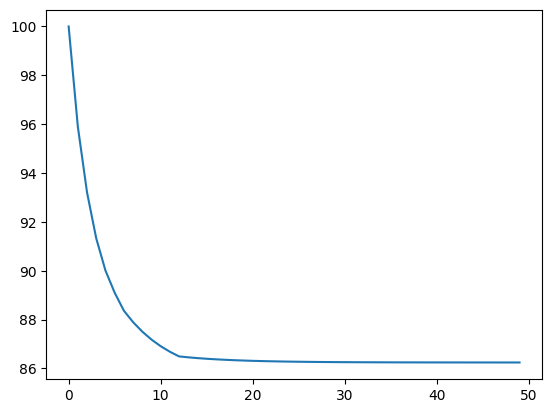

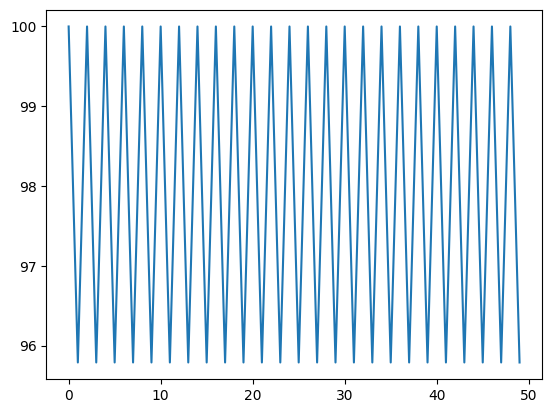

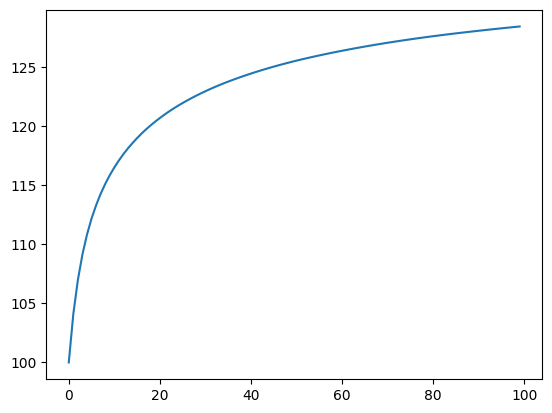

In [ ]:
# time periods, accuracy, rat. price, eq. price, spread, volume, shares, bias, form
price_hist = evolution_1(50, 40, 100, 100, 80, 100000, 1000, 1, 1)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(50, 20, 100, 100, 80, 200000, 1000, 1, 1)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(100, 40, 100, 100, 80, 100000000, 1000, 1, 1)
plt.plot(price_hist)
plt.show()

**Scenario 2:** Asset price evolution with no additional cost to shorting

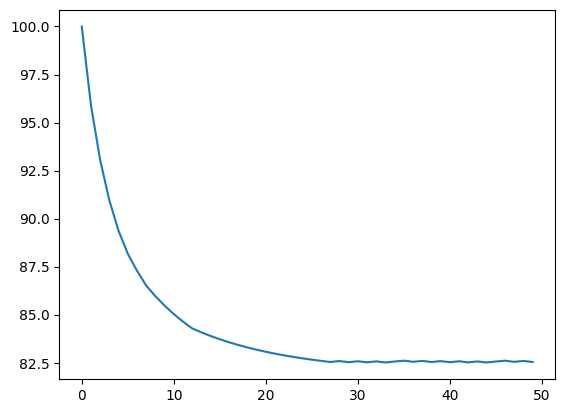

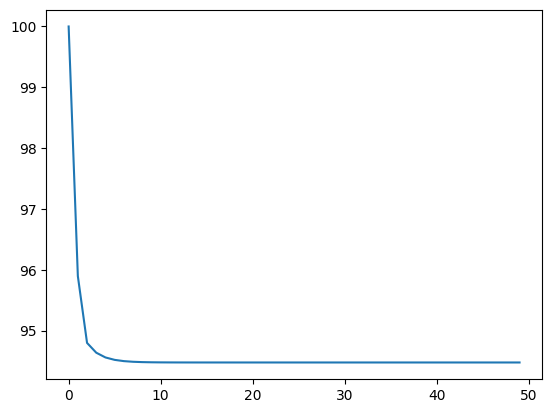

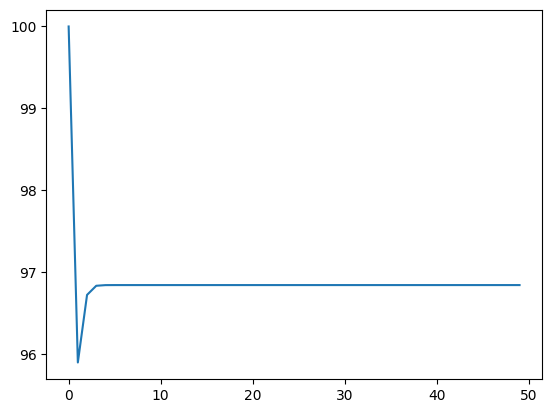

In [ ]:
# time periods, accuracy, rat. price, eq. price, spread, volume, shares, bias, form
price_hist = evolution_1(50, 40, 100, 100, 80, 100000, 1000, 1, 2)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(50, 40, 100, 100, 80, 300000, 1000, 1, 2)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(50, 40, 100, 100, 80, 600000, 1000, 1, 2)
plt.plot(price_hist)
plt.show()

**Scenario 3:** Shorting with bias

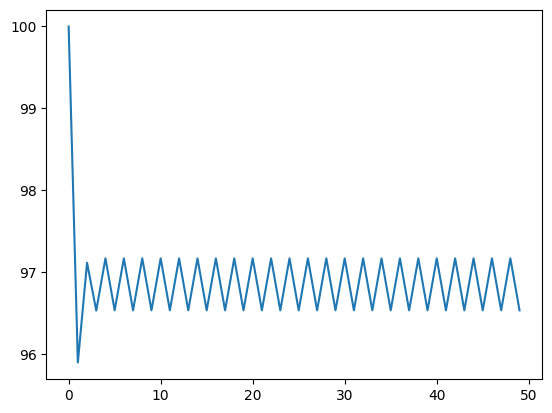

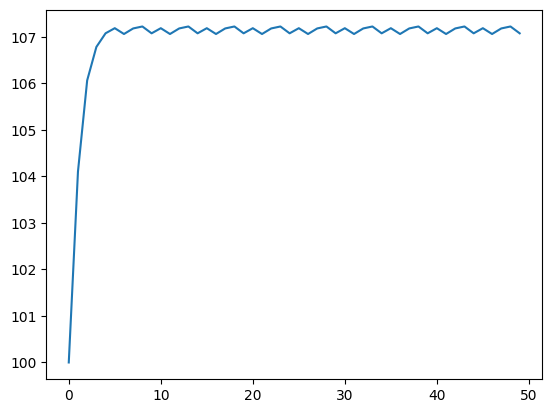

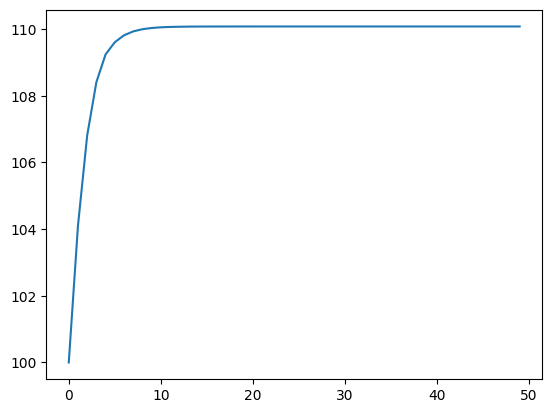

In [ ]:
# time periods, accuracy, rat. price, eq. price, spread, volume, shares, bias, form
price_hist = evolution_1(50, 40, 100, 100, 80, 500000, 1000, 0.9, 2)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(50, 40, 100, 100, 80, 500000, 1000, 0.2, 2)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(50, 40, 100, 100, 80, 10000000000, 1000, 0.2, 2)
plt.plot(price_hist)
plt.show()



**Scenario 4:** Auction with momentum trading

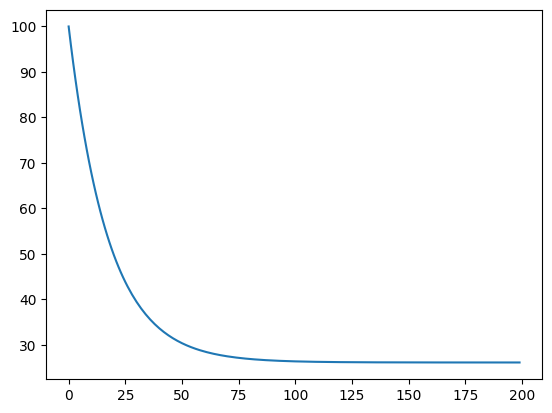

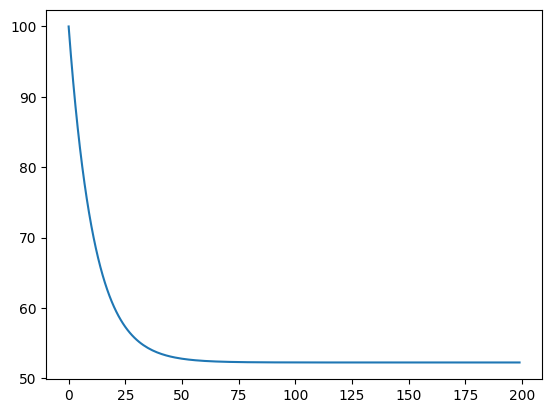

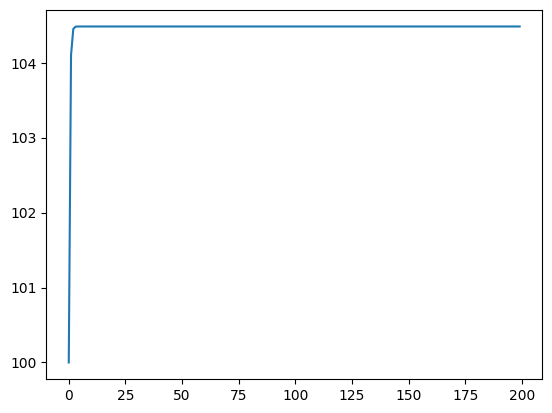

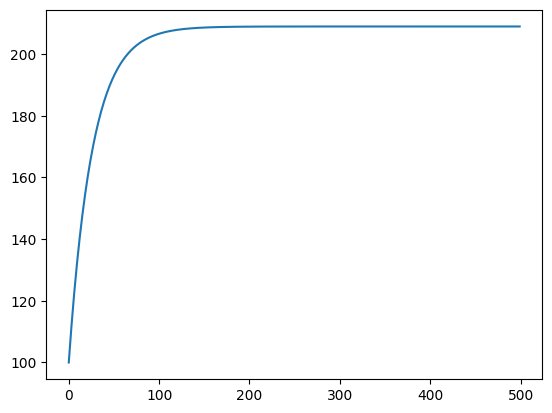

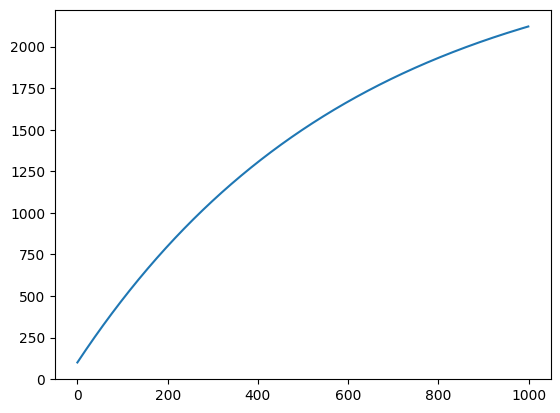

In [ ]:
price_hist = evolution_1(200, 40, 100, 100, 80, 100000, 1000, 0.5, 3)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(200, 40, 100, 100, 80, 200000, 1000, 0.5, 3)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(200, 40, 100, 100, 80, 400000, 1000, 0.5, 3)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(500, 40, 100, 100, 80, 800000, 1000, 0.5, 3)
plt.plot(price_hist)
plt.show()
price_hist = evolution_1(1000, 40, 100, 100, 80, 10000000, 1000, 0.5, 3)
plt.plot(price_hist)
plt.show()

**Scenario 5:** Auction with combined value and momentum investors (constant prop.)

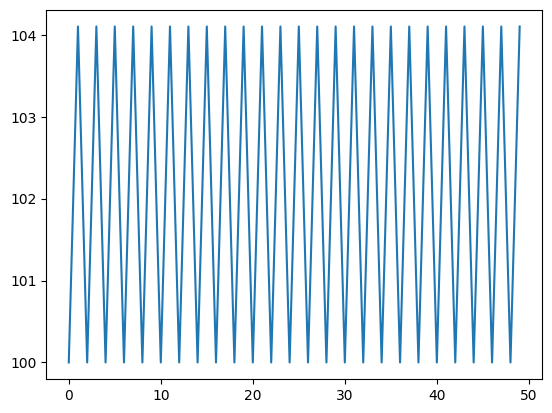

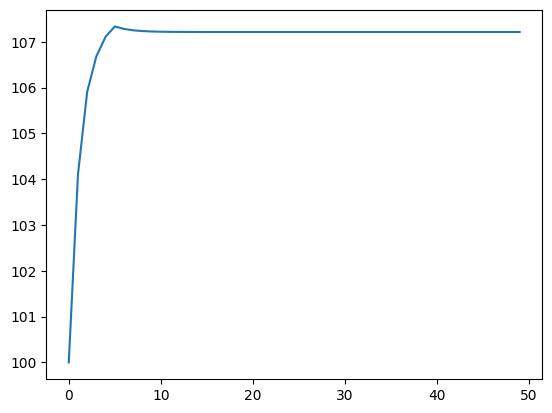

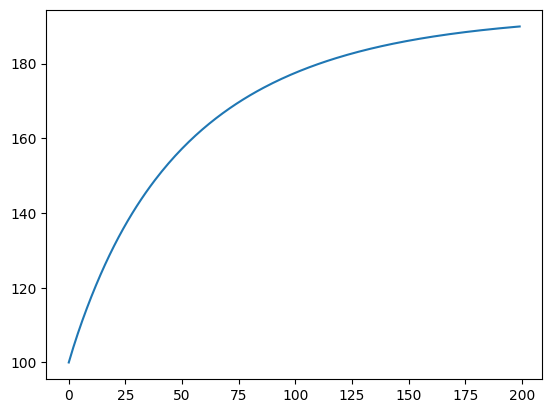

In [ ]:
# time periods, accuracy, rat. price, eq. price, spread, volume_hist, proportion_hist, shares, bias
time_periods = 50
volume_hist = [500000] * time_periods
proportion_hist = [0.5] * time_periods

price_hist = evolution_2(time_periods, 40, 100, 100, 80, volume_hist, proportion_hist, 1000, 0.5)
plt.plot(price_hist)
plt.show()

volume_hist = [10000000] * time_periods
price_hist = evolution_2(time_periods, 40, 100, 100, 80, volume_hist, proportion_hist, 1000, 0.5)
plt.plot(price_hist)
plt.show()

time_periods = 200
volume_hist = [10000000] * time_periods
proportion_hist = [0.9] * time_periods
price_hist = evolution_2(time_periods, 40, 100, 100, 40, volume_hist, proportion_hist, 1000, 0.2)
plt.plot(price_hist)
plt.show()

**Scenario 6:** Auction with exogenous increase in volume and proportion of momentum investors

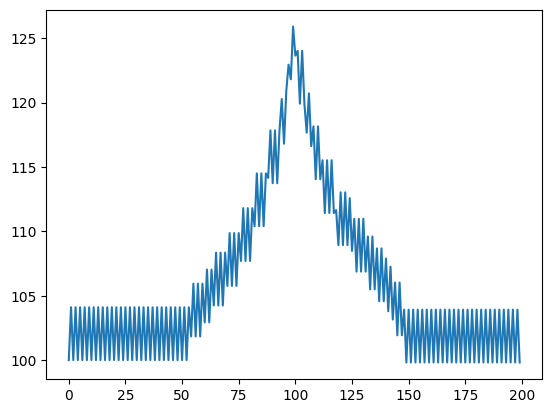

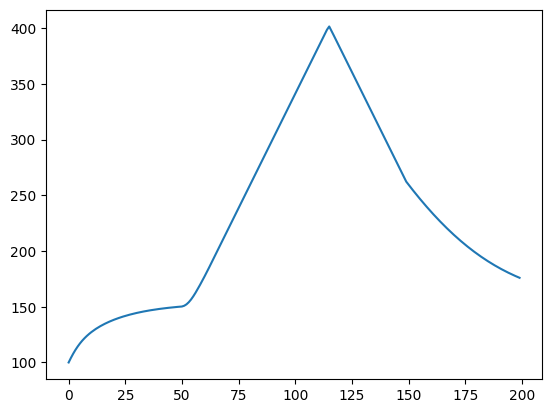

In [ ]:
# time periods, accuracy, rat. price, eq. price, spread, volume_hist, proportion_hist, shares, bias, proportion
time_periods = 200
volume_hist = [500000] * time_periods
proportion_hist = [0.5] * time_periods
for i in range(51, 101):
  volume_hist[i] += volume_hist[i] * ((i - 50)/10)
  proportion_hist[i] += proportion_hist[i] * ((i - 50)/70)
for i in range(101, 151):
  volume_hist[i] += volume_hist[i] * ((150 - i)/10)
  proportion_hist[i] += proportion_hist[i] * ((150 - i)/70)
price_hist = evolution_2(time_periods, 40, 100, 100, 80, volume_hist, proportion_hist, 1000, 0.5)
plt.plot(price_hist)
plt.show()

time_periods = 200
volume_hist = [5000000] * time_periods
proportion_hist = [0.5] * time_periods
for i in range(51, 101):
  volume_hist[i] += volume_hist[i] * ((i - 50))
  proportion_hist[i] += proportion_hist[i] * ((i - 50)/51)
for i in range(101, 151):
  volume_hist[i] += volume_hist[i] * ((150 - i))
  proportion_hist[i] += proportion_hist[i] * ((150 - i)/51)
price_hist = evolution_2(time_periods, 40, 100, 100, 80, volume_hist, proportion_hist, 1000, 0.1)
plt.plot(price_hist)
plt.show()